# Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("\n Loading data ... \n")
data = np.loadtxt('../data/ex2data2.txt', delimiter=',')
print("First 10 examples from the dataset:")
print(data[1:10,])

X = np.c_[data[:,[0,1]]]
y = np.c_[data[:,2]]


 Loading data ... 

First 10 examples from the dataset:
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]
 [-0.39804   0.034357  1.      ]
 [-0.30588  -0.19225   1.      ]
 [ 0.016705 -0.40424   1.      ]
 [ 0.13191  -0.51389   1.      ]]


## Visualizing the data

Function plotData is used to generate a figure where the axes are the two test scores, and the positive
(y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers

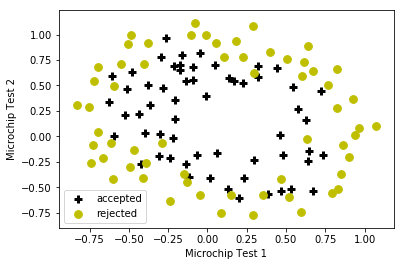

In [13]:
def plotData(X, y, label_x, label_y, label_pos, label_neg):
    """
    PLOTDATA Plots the data points X and y into a new figure 
    PLOTDATA(x,y) plots the data points with + for the positive examples
    and o for the negative examples. X is assumed to be a Mx2 numpy array.

    """
    # Get indexes for class 0 and class 1
    neg = np.squeeze(y == 0)
    pos = np.squeeze(y == 1)
    
    # plot examples
    axes = plt.gca()
    axes.scatter(x = X[pos, 0], y = X[pos, 1], c= 'black', marker= '+', s=60,
                linewidth=3, label=label_pos)
    axes.scatter(x = X[neg, 0], y = X[neg, 1], c='y', s=60, marker = 'o',
                label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True)


plotData(X, y, label_x =  'Microchip Test 1', label_y = 'Microchip Test 2',
         label_pos = 'accepted', label_neg = 'rejected')

The figure above shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-
forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

## Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function mapFeature, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ mapFeature(x) = 
\begin{bmatrix} 
1  \\
x_1  \\
x_2 \\
x_1^2 \\
x_1x_2 \\
x_2^2 \\
x_1^3 \\
\vdots \\
x_1x_2^5\\
x_2^6 \\
\end{bmatrix}$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you
will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [14]:
def mapFeature(X1, X2, degree = 6):
    # MAPFEATURE Feature mapping function to polynomial features

   # MAPFEATURE(X1, X2) maps the two input features
   # to quadratic features used in the regularization exercise.

   # Returns a new feature array with more features, comprising of 
   # X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

   # Inputs X1, X2 must be the same size
   out = np.ones(X1.shape[0])
   
   for i in range(1, degree+1):
       for j in range(0, i+1):
           out = np.c_[out, (X1**(i-j)) * (X2**j)]
   
   return out;

X = mapFeature(X[:, 0], X[:, 1]);

## Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Recall that the regularized cost function in logistic regression is

$$J(\theta) = - \frac{1}{m} \displaystyle \sum_{i=1}^m [y^{(i)}\log (h_\theta (x^{(i)})) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)}))] + 
\frac{\lambda}{2m} \sum_{j=1}^{n}\theta_j^2$$

Note that you should not regularize the parameter $\theta_0$.  The gradient of the cost function is a vector where the jth element is defined as follows:

for $j = 0$

$$ \frac{\partial J(\theta)}{\partial \theta_0} =
\frac{1}{m}\sum_{i=1}^m \left [ h_\theta(x^{(i)}) - y^{(i)} \right ] x^{(i)}_j $$

for $j \ge 1$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left(
\frac{1}{m}\sum_{i=1}^m \left [ h_\theta(x^{(i)}) - y^{(i)} \right ] x^{(i)}_j \right) + \frac{\lambda}{m} \theta_j
$$

In [15]:
def sigmoid(z):
    """
    SIGMOID Compute sigmoid functoon
    J = SIGMOID(z) computes the sigmoid of z.
    """
    return 1/(1 + np.exp(-z))

def costFunction(theta, X, y, Lambda):
    """
    COSTFUNCTION Compute cost for logistic regression with regularization
    J = COSTFUNCTION(theta, X, y, lambda) computes the cost of using
    theta as the parameter for regularized logistic regression
    """
    
    m = y.size  
    hetta = sigmoid(X.dot(theta)).reshape(y.shape)
    J = 1/m * np.sum(-y * np.log(hetta) - (1-y) * np.log(1-hetta), axis = 0) + Lambda/(2*m) * np.sum(theta[1:, ]**2, axis = 0)

    # if cost is nan return Inf
    if np.isnan(J[0]):
        return(np.inf)
    return J[0]

def gradFunction(theta, X, y, Lambda):
    
    """
    GRADFUNCTION Compute gradient for logistic regression
    gradFunction = GRADFUNCTION(theta, X, y) computes gradient of the cost
    for logistic regression w.r.t. to the parameters.
    """
    m = y.size
    
    hetta = sigmoid(X.dot(theta)).reshape(y.shape)
    grad = 1/m * np.sum((hetta - y)*(X), axis = 0, keepdims= True).T + Lambda/m * np.r_[[[0]],theta[1:].reshape(-1,1)]
    return grad.flatten()

def predict(theta, X):
    """
    PREDICT Compute predicted values for logistic regression
    predict = PREDICT(theta, X) computes predicted values
    for logistic regression w.r.t. to the parameters given
    the examples X.
    """
    return sigmoid(X.dot(theta.T))

## Plotting the decision boundary

In this part of the exercise, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

The code below plots the (non-linear) decision boundary that separates the positive and negative examples. We plot the non-linear decision boundary by computing the classifier's predictions on an evenly spaced grid and then draw a contour plot of where the predictions change from $y = 0$ to $y = 1$.

Notice the changes in the decision boundary as you vary $lambda$. With a small $lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts that a point at $x = (-0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.

With a larger $lambda$, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if $lambda$ is set to too high a value, you will not get a good fit and the decision
boundary will not follow the data so well, thus underfitting the data

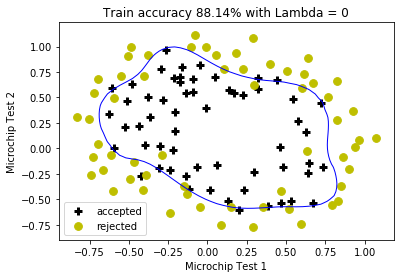

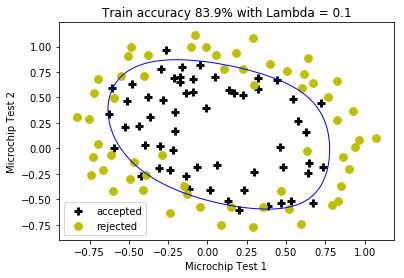

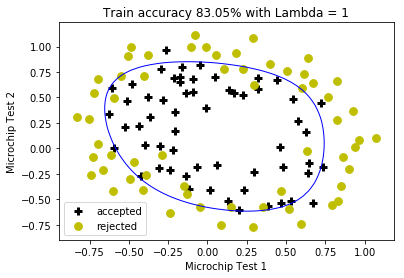

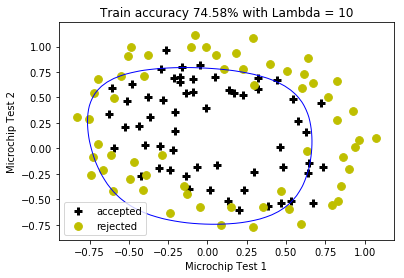

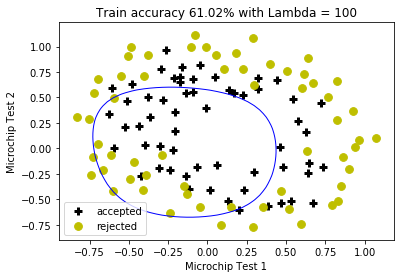

In [16]:
from scipy.optimize import minimize

# supress warnings from optimization
import warnings
warnings.simplefilter("ignore")

# Initialize fitting parameters
initial_theta = np.zeros([X.shape[1],1])

for Lambda in [0, 0.1, 1, 10, 100]:
    optim = minimize(fun = costFunction, x0=initial_theta, args=(X,y, Lambda), 
                 method='BFGS', jac=gradFunction,
                 options={'maxiter':400})
    # Accuracy
    accuracy = (100*sum( (predict(optim.x, X) >= 0.5) == y.ravel())/y.size)
    
    # create grid for desicion boundary
    x1_min, x1_max = X[:,1].min(), X[:,1].max()
    x2_min, x2_max = X[:,2].min(), X[:,2].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    
    plotData(data[:,[0,1]], y, label_x =  'Microchip Test 1', label_y = 'Microchip Test 2',
         label_pos = 'accepted', label_neg = 'rejected')
    h = sigmoid(mapFeature(xx1.ravel(), xx2.ravel()).dot(optim.x))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
    plt.title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), Lambda))
    plt.show()